## Constrained, Parallel, Multi-Objective BO in BoTorch with qEHVI and qParEGO

In this tutorial, we illustrate how to implement a constrained multi-objective (MO) Bayesian Optimization (BO) closed loop in BoTorch.

We use the parallel ParEGO ($q$ParEGO) [1] and parallel Expected Hypervolume Improvement ($q$EHVI) [1]  acquisition functions to optimize a synthetic C2-DTLZ2 test function with $M=2$ objectives, $V=1$ constraint, and $d=12$ parameters. The two objectives are
$$f_1(\mathbf x) = (1+ g(\mathbf x_M))\cos\big(\frac{\pi}{2}x_1\big)$$
$$f_2(\mathbf x) = (1+ g(\mathbf x_M))\sin\big(\frac{\pi}{2}x_1\big)$$
where $g(\mathbf x) = \sum_{x_i \in \mathbf x_M} (x_i - 0.5)^2, \mathbf x \in [0,1]^d,$ and $\mathbf x_M$ represents the last $d - M +1$ elements of $\mathbf x$. Additionally, the C2-DTLZ2 problem uses the following constraint:

$$c(\mathbf x) = - \min \bigg[\min_{i=1}^M\bigg((f_i(\mathbf x) -1 )^2 + \sum_{j=1, j=i}^M (f_j^2 - r^2) \bigg), \bigg(\sum_{i=1}^M \big((f_i(\mathbf x) - \frac{1}{\sqrt{M}})^2 - r^2\big)\bigg)\bigg]\geq 0$$

where $\mathbf x \in [0,1]^d$ and $r=0.2$. 

The goal here is to *minimize* both objectives. Since BoTorch assumes maximization, we maximize the negative of each objective. Since there typically is no single best solution in multi-objective optimization problems, we seek to find the pareto frontier, the set of optimal trade-offs where improving one metric means deteriorating another.

[1] [Samuel Daulton, Maximillian Balandat, Eytan Bakshy. Differentiable Expected Hypervolume Improvement for Parallel Multi-Objective Bayesian Optimization. ArXiv e-prints, 2020.](https://arxiv.org/abs/2006.05078)

### Set dtype and device
Note: $q$EHVI aggressively exploits parallel hardware and is much faster when run on a GPU. See [1] for details.

In [1]:
import torch
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

### Problem setup


In [2]:
from botorch.test_functions.multi_objective import C2DTLZ2
d = 12
M = 2
problem = C2DTLZ2(dim=d, num_objectives=M, negate=True).to(**tkwargs)

#### Model initialization

We use a multi-output `SingleTaskGP` to model the two objectives with a homoskedastic Gaussian likelihood with an inferred noise level.

The models are initialized with $2(d+1)=26$ points drawn randomly from $[0,1]^{12}$.

In [3]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import unnormalize
from botorch.utils.sampling import draw_sobol_samples

def generate_initial_data(n):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=n, seed=torch.randint(1000000, (1,)).item()).squeeze(0)
    train_obj = problem(train_x)
    # negative values imply feasibility in botorch
    train_con = -problem.evaluate_slack(train_x)
    return train_x, train_obj, train_con
    
def initialize_model(train_x, train_obj, train_con):
    # define models for objective and constraint
    train_y = torch.cat([train_obj, train_con], dim=-1)
    model = SingleTaskGP(train_x, train_y, outcome_transform=Standardize(m=train_y.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

#### Define a helper function that performs the essential BO step for $q$EHVI
The helper function below initializes the $q$EHVI acquisition function, optimizes it, and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values. 

For this example, we'll use a small batch of $q=2$. Passing the keyword argument `sequential=True` to the function `optimize_acqf`specifies that candidates should be optimized in a sequential greedy fashion (see [1] for details why this is important). A simple initialization heuristic is used to select the 20 restart initial locations from a set of 1024 random points. Multi-start optimization of the acquisition function is performed using LBFGS-B with exact gradients computed via auto-differentiation.

**Reference Point**

$q$EHVI requires specifying a reference point, which is the lower bound on the objectives used for computing hypervolume. In this tutorial, we assume the reference point is known. In practice the reference point can be set 1) using domain knowledge to be slightly worse than the lower bound of objective values, where the lower bound is the minimum acceptable value of interest for each objective, or 2) using a dynamic reference point selection strategy.

**Partitioning the Non-dominated Space into disjoint rectangles**

$q$EHVI requires partitioning the non-dominated space into disjoint rectangles (see [1] for details). 

*Note:* `NondominatedPartitioning` *will be very slow when 1) there are a lot of points on the pareto frontier and 2) there are >3 objectives.*

In [4]:
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decomposition import NondominatedPartitioning
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.utils.sampling import sample_simplex

BATCH_SIZE = 1
standard_bounds = torch.zeros(2, problem.dim, **tkwargs)
standard_bounds[1] = 1


def optimize_qehvi_and_get_observation(model, train_obj, train_con, sampler):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # compute feasible observations
    is_feas = (train_con <= 0).all(dim=-1)
    # compute points that are better than the known reference point
    better_than_ref = (train_obj > problem.ref_point).all(dim=-1)
    # partition non-dominated space into disjoint rectangles
    partitioning = NondominatedPartitioning(
        num_outcomes=problem.num_objectives, 
        # use observations that are better than the specified reference point and feasible
        Y=train_obj[better_than_ref & is_feas],  
    )
    acq_func = qExpectedHypervolumeImprovement(
        model=model,
        ref_point=problem.ref_point.tolist(),  # use known reference point 
        partitioning=partitioning,
        sampler=sampler,
        # define an objective that specifies which outcomes are the objectives
        objective=IdentityMCMultiOutputObjective(outcomes=[0, 1]),
        # specify that the constraint is on the last outcome
        constraints=[lambda Z: Z[..., -1]],
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=20,
        raw_samples=1024,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200, "nonnegative": True},
        sequential=True,
    )
    # observe new values 
    new_x =  unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj = problem(new_x)
    # negative values imply feasibility in botorch
    new_con = -problem.evaluate_slack(new_x)
    return new_x, new_obj, new_con

#### Define a helper function for creating constrained objectives for $q$ParEGO
The helper function below initializes a ConstrainedMCObjective for $q$ParEGO. It creates the `objective` which fetches the outcomes required for the scalarized objective and applies the scalarization and the constraints, which are modeled outcomes.


In [5]:
from botorch.acquisition.objective import ConstrainedMCObjective

def get_constrained_mc_objective(train_obj,train_con,scalarization):
    """Initialize a ConstrainedMCObjective for qParEGO"""
    n_obj = train_obj.shape[-1]
    # assume first outcomes of the model are the objectives, the rest constraints
    def objective(Z):
        return scalarization(Z[..., :n_obj])

    constrained_obj = ConstrainedMCObjective(
        objective=objective,
        constraints=[lambda Z: Z[..., -1]], # index the constraint
    )
    return constrained_obj

#### Define a helper function that performs the essential BO step for $q$ParEGO
The helper function below similarly initializes $q$ParEGO, optimizes it, and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values. 

$q$ParEGO uses random augmented chebyshev scalarization with the `qExpectedImprovement` acquisition function. In the parallel setting ($q>1$), each candidate is optimized in sequential greedy fashion using a different random scalarization (see [1] for details).

To do this, we create a list of `qExpectedImprovement` acquisition functions, each with different random scalarization weights. The `optimize_acqf_list` method sequentially generates one candidate per acquisition function and conditions the next candidate (and acquisition function) on the previously selected pending candidates.

In [6]:
def optimize_qparego_and_get_observation(model, train_obj, train_con, sampler):
    """Samples a set of random weights for each candidate in the batch, performs sequential greedy optimization 
    of the qParEGO acquisition function, and returns a new candidate and observation."""
    acq_func_list = []
    for _ in range(BATCH_SIZE):
        # sample random weights
        weights = sample_simplex(problem.num_objectives, **tkwargs).squeeze()
        # construct augmented Chebyshev scalarization
        scalarization = get_chebyshev_scalarization(weights=weights, Y=train_obj)
        # initialize ConstrainedMCObjective
        constrained_objective = get_constrained_mc_objective(train_obj=train_obj, train_con=train_con, scalarization=scalarization)
        train_y = torch.cat([train_obj, train_con], dim=-1)
        acq_func = qExpectedImprovement(  # pyre-ignore: [28]
            model=model,
            objective=constrained_objective,
            best_f=constrained_objective(train_y).max(),
            sampler=sampler,
        )
        acq_func_list.append(acq_func)
    # optimize
    candidates, _ = optimize_acqf_list(
        acq_function_list=acq_func_list,
        bounds=standard_bounds,
        num_restarts=20,
        raw_samples=1024,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values 
    new_x = unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj = problem(new_x)
    # negative values imply feasibility in botorch
    new_con = -problem.evaluate_slack(new_x)
    return new_x, new_obj, new_con

# Optuna Objective

In [7]:
import os

from botorch.test_functions import Hartmann
from botorch.utils.multi_objective.pareto import is_non_dominated
import torch

import optuna
from optuna import multi_objective as mo

n_startup_trials = 2*(d+1)


def optuna_objective(trial):
    xs = [trial.suggest_float(f"x{i}", problem.bounds[0, i].item(), problem.bounds[1, i].item()) for i in range(problem.dim)]
    xs = torch.Tensor(xs)

    obj = problem(xs)
    obj = obj.tolist()

    con = -problem.evaluate_slack(xs.unsqueeze(0))
    con = con.item()
    trial.set_user_attr("constraints", (con,))

    if trial.number >= n_startup_trials -1 :
        hv = Hypervolume(ref_point=problem.ref_point)
        
        train_obj = []
        train_con = []
        for t in mo.study.MultiObjectiveStudy(trial._trial.study).trials:
            if t.number == trial.number:
                continue  # Still running
            train_obj.append(list(t.values))
            train_con.append(list(t.user_attrs["constraints"]))
        train_obj = torch.Tensor(train_obj)
        train_con = torch.Tensor(train_con)
        
        is_feas = (train_con <= 0).all(dim=-1)
        feas_train_obj = train_obj[is_feas]
        pareto_mask = is_non_dominated(feas_train_obj)
        pareto_y = feas_train_obj[pareto_mask]
        # compute feasible hypervolume
        volume = hv.compute(pareto_y)
        
        trial.set_user_attr("volume", volume)

    return obj


def optuna_constraints_func(study, trial):
    return trial.user_attrs["constraints"]

### Perform Bayesian Optimization loop with $q$EHVI and $q$ParEGO
The Bayesian optimization "loop" for a batch size of $q$ simply iterates the following steps:
1. given a surrogate model, choose a batch of points $\{x_1, x_2, \ldots x_q\}$
2. observe $f(x)$ for each $x$ in the batch 
3. update the surrogate model. 


Just for illustration purposes, we run three trials each of which do `N_BATCH=50` rounds of optimization. The acquisition function is approximated using `MC_SAMPLES=128` samples.

*Note*: Running this may take a little while.

In [13]:
from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
import time

import warnings
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

N_TRIALS = 3
N_BATCH = 50
MC_SAMPLES = 256

verbose = False

hvs_qparego_all, hvs_qehvi_all, hvs_random_all, hvs_optuna_qparego_all, hvs_optuna_qehvi_all = [], [], [], [], []

hv = Hypervolume(ref_point=problem.ref_point)

# average over multiple trials
for trial in range(1, N_TRIALS + 1):
    torch.manual_seed(trial)
    
    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    
    # Optuna BoTorch (qParEGO)
    sampler = optuna.integration.BoTorchSampler(
        candidates_func=optuna.integration.botorch.qparego_candidates_func,
        constraints_func=optuna_constraints_func, n_startup_trials=n_startup_trials)
    study = mo.create_study(directions=["maximize"] * problem.num_objectives, sampler=sampler)
    study.optimize(optuna_objective, n_trials=N_BATCH + n_startup_trials)
    trials = study.get_trials(deepcopy=False)
    hvs_optuna_qparego = []
    for t in trials:
        if "volume" in t.user_attrs:
            hvs_optuna_qparego.append(t.user_attrs["volume"])
            
    # Optuna BoTorch (qEHVI)
    sampler = optuna.integration.BoTorchSampler(
        candidates_func=optuna.integration.botorch.qehvi_candidates_func,
        constraints_func=optuna_constraints_func, n_startup_trials=n_startup_trials)
    study = mo.create_study(directions=["maximize"] * problem.num_objectives, sampler=sampler)
    study.optimize(optuna_objective, n_trials=N_BATCH + n_startup_trials)
    trials = study.get_trials(deepcopy=False)
    hvs_optuna_qehvi = []
    for t in trials:
        if "volume" in t.user_attrs:
            hvs_optuna_qehvi.append(t.user_attrs["volume"])

    # Original BoTorch
    hvs_qparego, hvs_qehvi, hvs_random = [], [], []
    
    # call helper functions to generate initial training data and initialize model
    train_x_qparego, train_obj_qparego, train_con_qparego = generate_initial_data(n=2*(d+1))
    mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_qparego, train_con_qparego)
    
    train_x_qehvi, train_obj_qehvi, train_con_qehvi = train_x_qparego, train_obj_qparego, train_con_qparego
    train_x_random, train_obj_random, train_con_random = train_x_qparego, train_obj_qparego, train_con_qparego
    # compute hypervolume 
    mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_qehvi, train_con_qehvi)
    
    # compute pareto front
    is_feas = (train_con_qparego <= 0).all(dim=-1)
    feas_train_obj = train_obj_qparego[is_feas]
    pareto_mask = is_non_dominated(feas_train_obj)
    pareto_y = feas_train_obj[pareto_mask]
    # compute hypervolume
    
    volume = hv.compute(pareto_y)
    
    hvs_qparego.append(volume)
    hvs_qehvi.append(volume)
    hvs_random.append(volume)
    
    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_BATCH + 1):    
        
        t0 = time.time()
        
        # fit the models
        fit_gpytorch_model(mll_qparego)
        fit_gpytorch_model(mll_qehvi)
        
        # define the qEI and qNEI acquisition modules using a QMC sampler
        qparego_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
        qehvi_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
        
        # optimize acquisition functions and get new observations
        new_x_qparego, new_obj_qparego, new_con_qparego = optimize_qparego_and_get_observation(
            model_qparego, train_obj_qparego, train_con_qparego, qparego_sampler
        )
        new_x_qehvi, new_obj_qehvi, new_con_qehvi = optimize_qehvi_and_get_observation(
            model_qehvi, train_obj_qehvi, train_con_qehvi, qehvi_sampler
        )
        new_x_random, new_obj_random, new_con_random = generate_initial_data(n=BATCH_SIZE)
                
        # update training points
        train_x_qparego = torch.cat([train_x_qparego, new_x_qparego])
        train_obj_qparego = torch.cat([train_obj_qparego, new_obj_qparego])
        train_con_qparego = torch.cat([train_con_qparego, new_con_qparego])

        train_x_qehvi = torch.cat([train_x_qehvi, new_x_qehvi])
        train_obj_qehvi = torch.cat([train_obj_qehvi, new_obj_qehvi])
        train_con_qehvi = torch.cat([train_con_qehvi, new_con_qehvi])
    
        train_x_random = torch.cat([train_x_random, new_x_random])
        train_obj_random = torch.cat([train_obj_random, new_obj_random])
        train_con_random = torch.cat([train_con_random, new_con_random])
        

        # update progress
        for hvs_list, train_obj, train_con in zip(
            (hvs_random, hvs_qparego, hvs_qehvi), 
            (train_obj_random, train_obj_qparego, train_obj_qehvi),
            (train_con_random, train_con_qparego, train_con_qehvi),
        ):
            # compute pareto front
            is_feas = (train_con <= 0).all(dim=-1)
            feas_train_obj = train_obj[is_feas]
            pareto_mask = is_non_dominated(feas_train_obj)
            pareto_y = feas_train_obj[pareto_mask]
            # compute feasible hypervolume
            volume = hv.compute(pareto_y)
            hvs_list.append(volume)

        # reinitialize the models so they are ready for fitting on next iteration
        # Note: we find improved performance from not warm starting the model hyperparameters
        # using the hyperparameters from the previous iteration
        mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_qparego, train_con_qparego)
        mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_qehvi, train_con_qehvi)
        
        t1 = time.time()
        
        if verbose:
            print(
                f"\nBatch {iteration:>2}: Hypervolume (random, qParEGO, qEHVI) = "
                f"({hvs_random[-1]:>4.2f}, {hvs_qparego[-1]:>4.2f}, {hvs_qehvi[-1]:>4.2f}), "
                f"time = {t1-t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")
   
    hvs_qparego_all.append(hvs_qparego)
    hvs_qehvi_all.append(hvs_qehvi)
    hvs_random_all.append(hvs_random)
    hvs_optuna_qparego_all.append(hvs_optuna_qparego)
    hvs_optuna_qehvi_all.append(hvs_optuna_qehvi)

/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:32: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/integration/botorch.py:407: ExperimentalWarning: RandomMultiObjectiveSampler is experimental (supported from v1.4.0). The interface can change in the future.
  self._independent_sampler = independent_sampler or RandomMultiObjectiveSampler()
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:33: ExperimentalWarning: create_study is experimental (supported from v1.4.0). The interface can change in the future.
[I 2020-12-14 21:46:36,182] A new study created in memory with name: no-name-0b57e2aa-5887-45a3-af45-d3b29f1d9c12
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:133: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in t


Trial  1 of 3 

[I 2020-12-14 21:46:36,430] Trial 3 finished with values: [-1.9745843410491943, -0.27776023745536804] with parameters: {'x0': 0.08896808590210492, 'x1': 0.45258729490411065, 'x2': 0.029272197879817163, 'x3': 0.3948921895564381, 'x4': 0.1172290401873084, 'x5': 0.0662135240261712, 'x6': 0.035114935002978465, 'x7': 0.5783936664779097, 'x8': 0.835165964131644, 'x9': 0.6527607412073749, 'x10': 0.5407798258077138, 'x11': 0.7546787192041448}.
[I 2020-12-14 21:46:36,492] Trial 4 finished with values: [-2.1148765087127686, -0.4761768877506256] with parameters: {'x0': 0.1409875881474576, 'x1': 0.31041900492823715, 'x2': 0.21562718416749038, 'x3': 0.9213589574406029, 'x4': 0.3504539035063503, 'x5': 0.17189449430300574, 'x6': 0.1130691686962374, 'x7': 0.6963306154752271, 'x8': 0.11549999352816542, 'x9': 0.11261084283114065, 'x10': 0.005007230324598488, 'x11': 0.38926794828225564}.
[I 2020-12-14 21:46:36,554] Trial 5 finished with values: [-1.5340583324432373, -1.1507290601730347] with parameters: 

[I 2020-12-14 21:46:37,612] Trial 22 finished with values: [-1.44493567943573, -1.428484559059143] with parameters: {'x0': 0.49635523532341497, 'x1': 0.9774248581545787, 'x2': 0.8000780239344129, 'x3': 0.55994944721498, 'x4': 0.024595906345774687, 'x5': 0.697711164415934, 'x6': 0.5053465189209352, 'x7': 0.08472063589338286, 'x8': 0.6577621059243487, 'x9': 0.8321894603755012, 'x10': 0.4236875423005244, 'x11': 0.8628033182571422}.
[I 2020-12-14 21:46:37,671] Trial 23 finished with values: [-1.4073046445846558, -1.1720542907714844] with parameters: {'x0': 0.4420973040342573, 'x1': 0.47874729391417403, 'x2': 0.45851138656834134, 'x3': 0.9610196177343149, 'x4': 0.41107979260313987, 'x5': 0.05192996174623987, 'x6': 0.8342234250641583, 'x7': 0.28363804253094416, 'x8': 0.6158519847964828, 'x9': 0.4355495074821176, 'x10': 0.044101441218806325, 'x11': 0.6553379233891639}.
[I 2020-12-14 21:46:37,729] Trial 24 finished with values: [-1.8014129400253296, -1.4699259996414185] with parameters: {'x0':

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:133: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  return MultiObjectiveStudy(study)
/Users/hvy/repos/optuna/optuna/multi_objective/samplers/_adapter.py:25: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  mo_study = multi_objective.study.MultiObjectiveStudy(study)
/Users/hvy/repos/optuna/optuna/multi_objective/samplers/_adapter.py:26: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.FrozenMultiObjectiveTrial(mo_study.n_objectives, trial)
/Users/hvy/repos/optuna/optuna/multi_objective/samplers/_adapter.py:32: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  mo_study = multi_objective.study.Multi

[I 2020-12-14 21:50:29,954] Trial 15 finished with values: [-0.9051939845085144, -1.565117597579956] with parameters: {'x0': 0.6661870594655495, 'x1': 0.14000393533624744, 'x2': 0.38405683409892133, 'x3': 0.5465781437204965, 'x4': 0.8670157838164958, 'x5': 0.08328984377066817, 'x6': 0.39956285791153423, 'x7': 0.5429843742528369, 'x8': 0.8137610376962129, 'x9': 0.18625895705191986, 'x10': 0.8649772806158313, 'x11': 0.38842638076510017}.
[I 2020-12-14 21:50:30,020] Trial 16 finished with values: [-2.0205814838409424, -0.29106050729751587] with parameters: {'x0': 0.09107723999317596, 'x1': 0.7148801868074713, 'x2': 0.8460429709039969, 'x3': 0.9984031840216173, 'x4': 0.07466040864505907, 'x5': 0.3222343473870338, 'x6': 0.6973685672532469, 'x7': 0.19080750527992196, 'x8': 0.19189701093030054, 'x9': 0.2564156358247367, 'x10': 0.5969409906164369, 'x11': 0.15884759389913705}.
[I 2020-12-14 21:50:30,085] Trial 17 finished with values: [-2.053513526916504, -0.17678497731685638] with parameters: 

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

.................................................

/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:32: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/integration/botorch.py:407: ExperimentalWarning: RandomMultiObjectiveSampler is experimental (supported from v1.4.0). The interface can change in the future.
  self._independent_sampler = independent_sampler or RandomMultiObjectiveSampler()
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:33: ExperimentalWarning: create_study is experimental (supported from v1.4.0). The interface can change in the future.
[I 2020-12-14 22:09:03,953] A new study created in memory with name: no-name-8fbcc540-3357-45b7-972b-bf33da499a4d
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:133: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in t

.
Trial  2 of 3 

[I 2020-12-14 22:09:04,178] Trial 1 finished with values: [-1.7989834547042847, -0.8878568410873413] with parameters: {'x0': 0.29186485157899467, 'x1': 0.29620662198055225, 'x2': 0.28348576404435777, 'x3': 0.36458904422540106, 'x4': 0.016379583518663865, 'x5': 0.9658372091488476, 'x6': 0.8007915126426244, 'x7': 0.3531249440676215, 'x8': 0.8923888870126045, 'x9': 0.13483603618560147, 'x10': 0.5419343396695127, 'x11': 0.7176902319389757}.
[I 2020-12-14 22:09:04,240] Trial 2 finished with values: [-1.9155980348587036, -0.6077027916908264] with parameters: {'x0': 0.1955674095722798, 'x1': 0.614210067209713, 'x2': 0.7172503292898582, 'x3': 0.5967040468321022, 'x4': 0.9595688603814877, 'x5': 0.9011877961374472, 'x6': 0.40927405702758035, 'x7': 0.12012498977822328, 'x8': 0.13877071650484762, 'x9': 0.7822084662828102, 'x10': 0.05660206099885756, 'x11': 0.4069054873014769}.
[I 2020-12-14 22:09:04,322] Trial 3 finished with values: [-1.1877681016921997, -0.9773193001747131] with parameters: {'x0

[I 2020-12-14 22:09:05,481] Trial 20 finished with values: [-0.3378307819366455, -1.9226484298706055] with parameters: {'x0': 0.8892690860511755, 'x1': 0.3119204417520818, 'x2': 0.9302476483034596, 'x3': 0.28949363156546193, 'x4': 0.7444357086775301, 'x5': 0.2139525480433987, 'x6': 0.6741779072723209, 'x7': 0.7890375130070734, 'x8': 0.09776378791247964, 'x9': 0.8871730221572031, 'x10': 0.8348124516803909, 'x11': 0.5897452710806669}.
[I 2020-12-14 22:09:05,552] Trial 21 finished with values: [-0.7155477404594421, -1.6255625486373901] with parameters: {'x0': 0.7360181684027077, 'x1': 0.6607827374124253, 'x2': 0.6666735350319499, 'x3': 0.553104439187723, 'x4': 0.8767384854711494, 'x5': 0.9697018901383966, 'x6': 0.906089479519981, 'x7': 0.35073195860485085, 'x8': 0.12103439200683441, 'x9': 0.48755981262568404, 'x10': 0.6613081282298103, 'x11': 0.4900938728572185}.
[I 2020-12-14 22:09:05,613] Trial 22 finished with values: [-1.6968286037445068, -1.0770548582077026] with parameters: {'x0': 0

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:133: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  return MultiObjectiveStudy(study)
/Users/hvy/repos/optuna/optuna/multi_objective/samplers/_adapter.py:25: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  mo_study = multi_objective.study.MultiObjectiveStudy(study)
/Users/hvy/repos/optuna/optuna/multi_objective/samplers/_adapter.py:26: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.FrozenMultiObjectiveTrial(mo_study.n_objectives, trial)
/Users/hvy/repos/optuna/optuna/multi_objective/samplers/_adapter.py:32: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  mo_study = multi_objective.study.Multi

[I 2020-12-14 22:14:19,010] Trial 15 finished with values: [-0.4668003022670746, -1.8059042692184448] with parameters: {'x0': 0.838967554301356, 'x1': 0.9631379704882244, 'x2': 0.17338800165724666, 'x3': 0.9476497899296729, 'x4': 0.01689839071007837, 'x5': 0.2419662021357657, 'x6': 0.4732747082627794, 'x7': 0.5782630380293984, 'x8': 0.5862032153762553, 'x9': 0.5453906917600823, 'x10': 0.4042711241145871, 'x11': 0.3649676851752002}.
[I 2020-12-14 22:14:19,079] Trial 16 finished with values: [-0.6109047532081604, -1.5223286151885986] with parameters: {'x0': 0.757051014197961, 'x1': 0.842030171257772, 'x2': 0.7135802352968451, 'x3': 0.16453993801406408, 'x4': 0.15457409265315514, 'x5': 0.6234299754063822, 'x6': 0.23570337514604478, 'x7': 0.6125579832767709, 'x8': 0.4934702282359066, 'x9': 0.4229107966781974, 'x10': 0.4601171970358653, 'x11': 0.874893824140444}.
[I 2020-12-14 22:14:19,148] Trial 17 finished with values: [-0.3449229896068573, -1.9863743782043457] with parameters: {'x0': 0.8

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

.................................................

/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:32: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/integration/botorch.py:407: ExperimentalWarning: RandomMultiObjectiveSampler is experimental (supported from v1.4.0). The interface can change in the future.
  self._independent_sampler = independent_sampler or RandomMultiObjectiveSampler()
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:33: ExperimentalWarning: create_study is experimental (supported from v1.4.0). The interface can change in the future.
[I 2020-12-14 22:29:36,719] A new study created in memory with name: no-name-dc21e505-e190-4d7e-aa65-6e34135b3036
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:133: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in t

.
Trial  3 of 3 

[I 2020-12-14 22:29:37,046] Trial 1 finished with values: [-1.4183162450790405, -0.9487736821174622] with parameters: {'x0': 0.3753365486929229, 'x1': 0.4621204026645226, 'x2': 0.35415935582074376, 'x3': 0.9992274206113482, 'x4': 0.8803438826044891, 'x5': 0.5430533536115291, 'x6': 0.44934693418208504, 'x7': 0.3839669105139528, 'x8': 0.4746630215153361, 'x9': 0.08925188094151071, 'x10': 0.8154817858505592, 'x11': 0.44490044109028937}.
[I 2020-12-14 22:29:37,105] Trial 2 finished with values: [-1.706008791923523, -0.843267560005188] with parameters: {'x0': 0.2922538570955805, 'x1': 0.2680880667485068, 'x2': 0.5538115118729565, 'x3': 0.6579426097140114, 'x4': 0.18753560744655118, 'x5': 0.01814372208744941, 'x6': 0.2613221705672243, 'x7': 0.664938406195319, 'x8': 0.05687269431977793, 'x9': 0.16731554939498772, 'x10': 0.6157286896455685, 'x11': 0.7949432435538601}.
[I 2020-12-14 22:29:37,164] Trial 3 finished with values: [-1.975714087486267, -0.14382962882518768] with parameters: {'x0': 0.

[I 2020-12-14 22:29:38,167] Trial 20 finished with values: [-1.0481806993484497, -1.4237778186798096] with parameters: {'x0': 0.5959957221413968, 'x1': 0.6095297431871246, 'x2': 0.23757768704377058, 'x3': 0.5531227320297122, 'x4': 0.7023136060878512, 'x5': 0.27118954977083387, 'x6': 0.3838600352642586, 'x7': 0.11526367005636862, 'x8': 0.10557413365905233, 'x9': 0.3307834440090617, 'x10': 0.09073718301624323, 'x11': 0.22103982283615542}.
[I 2020-12-14 22:29:38,225] Trial 21 finished with values: [-0.7592763900756836, -1.8439385890960693] with parameters: {'x0': 0.7513296056469482, 'x1': 0.9210267851946319, 'x2': 0.855146171036886, 'x3': 0.11315469991485905, 'x4': 0.4786417245504341, 'x5': 0.8951299837538952, 'x6': 0.5537101307151814, 'x7': 0.17248222368813904, 'x8': 0.5129289109118561, 'x9': 0.9929954494805893, 'x10': 0.474731537261726, 'x11': 0.6746873668248471}.
[I 2020-12-14 22:29:38,282] Trial 22 finished with values: [-1.868144154548645, -0.8499810099601746] with parameters: {'x0':

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:133: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  return MultiObjectiveStudy(study)
/Users/hvy/repos/optuna/optuna/multi_objective/samplers/_adapter.py:25: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  mo_study = multi_objective.study.MultiObjectiveStudy(study)
/Users/hvy/repos/optuna/optuna/multi_objective/samplers/_adapter.py:26: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.FrozenMultiObjectiveTrial(mo_study.n_objectives, trial)
/Users/hvy/repos/optuna/optuna/multi_objective/samplers/_adapter.py:32: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  mo_study = multi_objective.study.Multi

[I 2020-12-14 22:34:24,898] Trial 15 finished with values: [-1.5137461423873901, -0.20275859534740448] with parameters: {'x0': 0.08476744090090427, 'x1': 0.20668647920467342, 'x2': 0.14646247434761261, 'x3': 0.26049596970422273, 'x4': 0.6098044966798768, 'x5': 0.2179328131029623, 'x6': 0.6183391903512542, 'x7': 0.6690931552038972, 'x8': 0.6782024245913852, 'x9': 0.24803579132730846, 'x10': 0.6674316579361295, 'x11': 0.5372849085176117}.
[I 2020-12-14 22:34:24,957] Trial 16 finished with values: [-0.5766299366950989, -1.4623628854751587] with parameters: {'x0': 0.7608888315543519, 'x1': 0.9102828841265946, 'x2': 0.649173968941102, 'x3': 0.47323306295715883, 'x4': 0.7010900042362208, 'x5': 0.1555339584411376, 'x6': 0.4728266403738335, 'x7': 0.21946961848919533, 'x8': 0.4368222112228519, 'x9': 0.6372685691864818, 'x10': 0.1547873635535697, 'x11': 0.5103342087953578}.
[I 2020-12-14 22:34:25,014] Trial 17 finished with values: [-1.0801942348480225, -1.6695640087127686] with parameters: {'x0

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

/Users/hvy/repos/optuna/optuna/multi_objective/study.py:316: ExperimentalWarning: MultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  mo_trial = multi_objective.trial.MultiObjectiveTrial(trial)
/Users/hvy/repos/optuna/optuna/multi_objective/trial.py:43: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
  self._n_objectives = multi_objective.study.MultiObjectiveStudy(trial.study).n_objectives
/Users/hvy/.pyenv/versions/3.7.6/envs/3.7.6-optuna/lib/python3.7/site-packages/ipykernel_launcher.py:29: ExperimentalWarning: MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
/Users/hvy/repos/optuna/optuna/multi_objective/study.py:443: ExperimentalWarning: FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.
  for t in self._study.get_trials(deepcopy=deepcopy, states=states

..................................................

#### Plot the results
The plot below shows the log feasible hypervolume difference: the log difference between the hypervolume of the true feasible pareto front and the hypervolume of the observed (feasible) pareto front identified by each algorithm. The log feasible hypervolume difference is plotted at each step of the optimization for each of the algorithms. The confidence intervals represent the variance at that step in the optimization across the trial runs. The variance across optimization runs is quite high, so in order to get a better estimate of the average performance one would have to run a much larger number of trials `N_TRIALS` (we avoid this here to limit the runtime of this tutorial). 

The plot show that $q$EHVI vastly outperforms the $q$ParEGO and Sobol baselines.

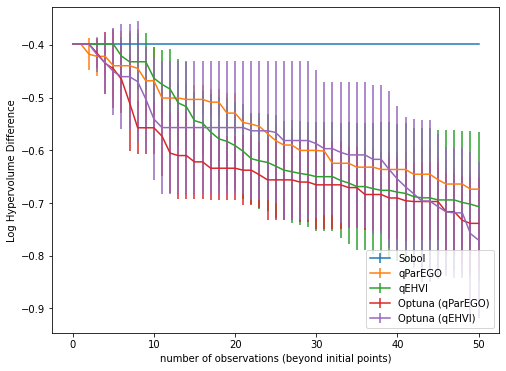

In [14]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

iters = np.arange(N_BATCH + 1) * BATCH_SIZE
log_hv_difference_qparego = np.log10(problem.max_hv - np.asarray(hvs_qparego_all))
log_hv_difference_qehvi = np.log10(problem.max_hv - np.asarray(hvs_qehvi_all))
log_hv_difference_rnd = np.log10(problem.max_hv - np.asarray(hvs_random_all))
log_hv_difference_optuna_qparego = np.log10(problem.max_hv - np.asarray(hvs_optuna_qparego_all))
log_hv_difference_optuna_qehvi = np.log10(problem.max_hv - np.asarray(hvs_optuna_qehvi_all))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, log_hv_difference_rnd.mean(axis=0), yerr=ci(log_hv_difference_rnd), label="Sobol", linewidth=1.5)
ax.errorbar(iters, log_hv_difference_qparego.mean(axis=0), yerr=ci(log_hv_difference_qparego), label="qParEGO", linewidth=1.5)
ax.errorbar(iters, log_hv_difference_qehvi.mean(axis=0), yerr=ci(log_hv_difference_qehvi), label="qEHVI", linewidth=1.5)
ax.errorbar(iters, log_hv_difference_optuna_qparego.mean(axis=0), yerr=ci(log_hv_difference_optuna_qparego), label="Optuna (qParEGO)", linewidth=1.5)
ax.errorbar(iters, log_hv_difference_optuna_qehvi.mean(axis=0), yerr=ci(log_hv_difference_optuna_qehvi), label="Optuna (qEHVI)", linewidth=1.5)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='Log Hypervolume Difference')
ax.legend(loc="lower right")

#### plot the observations colored by iteration

To examine optimization process from another perspective, we plot the collected observations under each algorithm where the color corresponds to the BO iteration at which the point was collected. The plot on the right for $q$EHVI shows that the $q$EHVI quickly identifies the pareto front and most of its evaluations are very close to the pareto front. $q$ParEGO also identifies has many observations close to the pareto front, but relies on optimizing random scalarizations, which is a less principled way of optimizing the pareto front compared to $q$EHVI, which explicitly attempts focuses on improving the pareto front. Sobol generates random points and has few points close to the pareto front

In [ ]:
from matplotlib.cm import ScalarMappable
fig, axes = plt.subplots(1, 3, figsize=(17, 5))
algos = ["Sobol", "qParEGO", "qEHVI"]
cm = plt.cm.get_cmap('viridis')

batch_number = torch.cat([torch.zeros(2*(d+1)), torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]).numpy()
for i, train_obj in enumerate((train_obj_random, train_obj_qparego, train_obj_qehvi)):
    sc = axes[i].scatter(train_obj[:, 0].cpu().numpy(), train_obj[:,1].cpu().numpy(), c=batch_number, alpha=0.8)
    axes[i].set_title(algos[i])
    axes[i].set_xlabel("Objective 1")
    axes[i].set_xlim(-2.5, 0)
    axes[i].set_ylim(-2.5, 0)
axes[0].set_ylabel("Objective 2")
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")